<a href="https://colab.research.google.com/github/anna030608/DS/blob/master/Quest/260204_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 탐지 분류 문제

이 노트북의 다음 라이브러리 버전은 "파이썬 머신러닝 완벽 가이드 개정2판"을 기준으로 설정되었습니다.

### 라이브러리 버전
2. `xgboost` : 1.5.0
3. `lightgbm` : 3.3.2

### 기타 사용 라이브러리
1. `hyperopt`

In [1]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 3.1.3
Uninstalling xgboost-3.1.3:
  Successfully uninstalled xgboost-3.1.3
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [2]:
!pip install xgboost==1.5.0 lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.8 MB/s eta 0:00:00


In [3]:
!pip install hyperopt

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# 데이터셋 정보

2013년 9월 유럽 신용카드 사용자들의 거래 내역을 포함하고 있습니다.
이 데이터셋은 이틀 간의 거래 내역으로 데이터셋은 크게 불균형하며, 사기 거래(양성 클래스)는 전체 거래의 약 0.17%에 불과합니다.

이 데이터셋은 PCA 변환을 거친 수치형 변수들만 포함하고 있습니다. 안타깝게도 기밀 유지 문제로 인해 원본 특징과 데이터에 대한 자세한 배경 정보는 제공할 수 없습니다. V1, V2, …, V28은 PCA로 얻은 주성분이며, PCA 변환을 거치지 않은 유일한 특징은 'Time'과 'Amount'입니다. 'Time'은 각 거래와 데이터셋의 첫 거래 사이의 경과 시간(초)을 나타내며, 'Amount'는 거래 금액입니다. 'Amount' 특징은 예시 의존적 비용 민감 학습 등에 사용될 수 있습니다. 'Class'는 응답 변수로, 사기 거래인 경우 1, 그렇지 않은 경우 0의 값을 가집니다.

클래스 불균형 비율을 고려하여, 정밀도-재현율 곡선 아래 영역(AUPRC)을 사용하여 정확도를 측정할 것을 권장합니다. 불균형 분류에서는 혼동 행렬 정확도가 큰 의미가 없습니다.

이 데이터셋은 Worldline과 ULB(브뤼셀 자유 대학교) 머신러닝 그룹(http://mlg.ulb.ac.be) 간의 빅데이터 마이닝 및 사기 탐지 관련 연구 협력을 통해 수집 및 분석되었습니다.
관련 주제에 대한 현재 및 과거 프로젝트에 대한 자세한 내용은 https://www.researchgate.net/project/Fraud-detection-5 및 DefeatFraud 프로젝트 페이지에서 확인할 수 있습니다.

In [2]:
train_df.head(3)

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113923 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      113923 non-null  int64  
 1   Time    113923 non-null  float64
 2   V1      113923 non-null  float64
 3   V2      113923 non-null  float64
 4   V3      113923 non-null  float64
 5   V4      113923 non-null  float64
 6   V5      113923 non-null  float64
 7   V6      113923 non-null  float64
 8   V7      113923 non-null  float64
 9   V8      113923 non-null  float64
 10  V9      113923 non-null  float64
 11  V10     113923 non-null  float64
 12  V11     113923 non-null  float64
 13  V12     113923 non-null  float64
 14  V13     113923 non-null  float64
 15  V14     113923 non-null  float64
 16  V15     113923 non-null  float64
 17  V16     113923 non-null  float64
 18  V17     113923 non-null  float64
 19  V18     113923 non-null  float64
 20  V19     113923 non-null  float64
 21  V20     11

In [5]:
train_df['Class'].value_counts()

,count
Class,
0,170523
1,360


<Axes: xlabel='Class'>

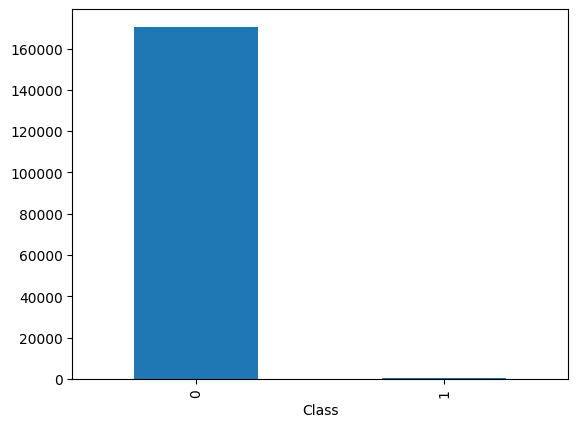

In [6]:
train_df['Class'].value_counts().plot(kind='bar')

사기 거래에 대한 클래스가 매우 적음

-> 클래스 불균형.

In [7]:
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [8]:
train_df['Amount'].value_counts().sort_index(ascending=False)

,count
Amount,
19656.53,1
18910.00,1
12910.93,1
11898.09,1
11789.84,1
...,...
0.04,6
0.03,1
0.02,47


거래 금액이 비정상적으로 큰 경우가 있음!!

- 이상치 여부 확인 필요하다고 판단.

<Axes: xlabel='Amount'>

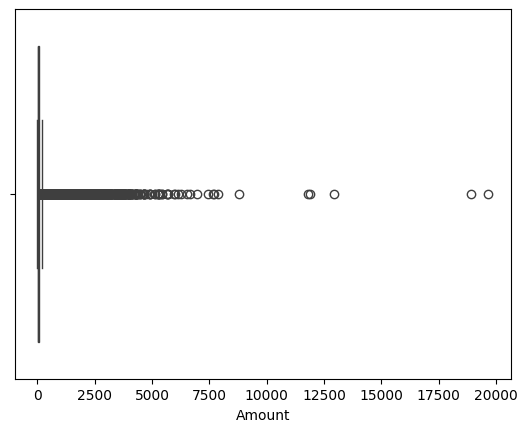

In [9]:
sns.boxplot(x=train_df['Amount'])

<Axes: xlabel='Amount', ylabel='Count'>

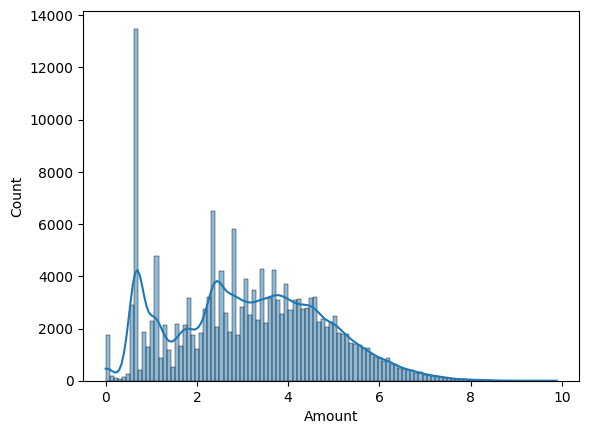

In [10]:
sns.histplot(np.log1p(train_df['Amount']), kde=True)

<Axes: xlabel='Amount', ylabel='Count'>

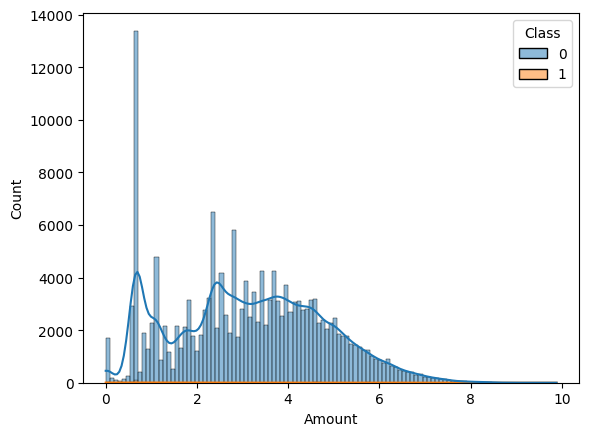

In [11]:
sns.histplot(data=train_df, x=np.log1p(train_df['Amount']), hue='Class', kde=True)

소액 결제가 매우 많음.

- 반복적인 소액 거래

또 중간 금액대에 밀집.

- 일반적인 소비 패턴이라 볼 수 있음

오른쪽 꼬리는 완만함.

- 고액 거래는 존재하지만, 빈도가 낮음.
---
Class 0 정상: 분포 전체를 독점.

Class 1 사기 : 거의 안보임. -> 데이터 불균형 때문.

---
-> 고액 = 사기 : X

-> 소액 = 정상 : X

=> 사기 거래는 특정 금액대에만 몰려 있지 않음!

In [12]:
# Time 분포

<Axes: xlabel='Time', ylabel='Count'>

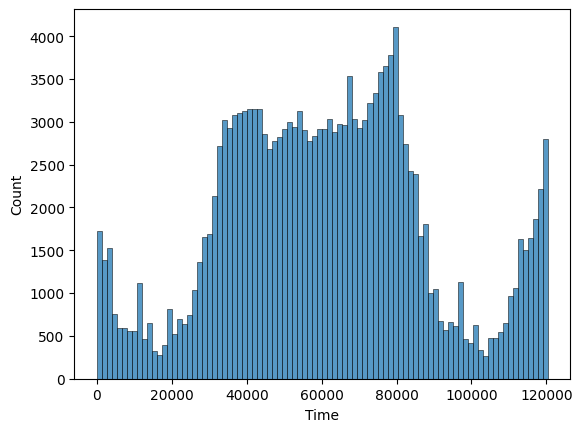

In [13]:
sns.histplot(train_df['Time'])

- Time 변수는 데이터셋 기준. 누적된 시간으로 정의되어 있기 때문에,

- 스케일 문제 및 해석상의 한계가 있을 것이라고 판단 -> 제외

In [14]:
# Amount , Time 변수 스케일링 필요.

# 뼈대 만들기

머신러닝 파이프라인은

데이터 준비 → 모델 정의 → 학습 → 예측 → 평가의 형태를 띕니다.

최소한의 형태로 파이프라인만 구성해 보겠습니다.

In [65]:
train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

In [66]:
X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [68]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64


In [69]:
from sklearn.linear_model import LogisticRegression

# 학습
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

# 검증
lr_val = lr_clf.predict(X_val)
lr_val_proba = lr_clf.predict_proba(X_val)[:,1]

print('학습 완료!')

학습 완료!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lr_val_confusion = confusion_matrix(y_val, lr_val)
lr_val_accuracy = accuracy_score(y_val, lr_val)
lr_val_precision = precision_score(y_val, lr_val)
lr_val_recall = recall_score(y_val, lr_val)
lr_val_f1 = f1_score(y_val, lr_val)

lr_val_roc_score = roc_auc_score(y_val, lr_val_proba)
print(lr_val_roc_score)

print("검증 데이터 혼동행렬:")
print(lr_val_confusion)
print("검증 데이터 정확도: ",lr_val_accuracy)
print("검증 데이터 정밀도: ",lr_val_precision)
print("검증 데이터 재현율: ",lr_val_recall)
print("검증 데이터 F1 점수: ",lr_val_f1)
print("검증 데이터 AUC: ",lr_val_roc_score)


0.9633741386893417
검증 데이터 혼동행렬:
[[34092    13]
 [   29    43]]
검증 데이터 정확도:  0.9987711033736139
검증 데이터 정밀도:  0.7678571428571429
검증 데이터 재현율:  0.5972222222222222
검증 데이터 F1 점수:  0.671875
검증 데이터 AUC:  0.9633741386893417


In [15]:
test_df.drop('Time', axis=1, inplace=True)
X_test_features = test_df.iloc[:, :]


# 예측
lr_prob = lr_clf.predict(X_test_features)

# 제출용 DataFrame
submission = pd.DataFrame({
    "id": test_df["id"],   # 반드시 원래 test.csv에 있던 id 사용
    "Class": lr_prob
})

# csv 파일 저장
submission.to_csv("./submission_v1.csv", index=False)

In [16]:
submission


,id,Class
0,170883,0
1,170884,0
2,170885,0
3,170886,0
4,170887,0
...,...,...
113918,284801,0
113919,284802,0
113920,284803,0
113921,284804,0


In [ ]:
# 모델 2 - XGBoost

In [70]:
from sklearn.model_selection import train_test_split

train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [71]:
# id 컬럼 제외.
drop_cols = []
if 'id' in X_train.columns:
    drop_cols.append('id')

X_tr = X_train.drop(columns=drop_cols) if drop_cols else X_train
X_va = X_val.drop(columns=drop_cols) if drop_cols else X_val

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 473.6736111111111


In [19]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    early_stopping_rounds=100,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

In [20]:
xgb_clf.fit(
    X_tr, y_train,
    eval_set=[(X_va, y_val)],
    verbose=200,
)

[0]	validation_0-logloss:0.65115
[200]	validation_0-logloss:0.00300
[382]	validation_0-logloss:0.00275


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [21]:
xgb_val_proba = xgb_clf.predict_proba(X_va)[:, 1]
xgb_val = (xgb_val_proba >= 0.5).astype(int)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

xgb_val_confusion = confusion_matrix(y_val, xgb_val)
xgb_val_accuracy  = accuracy_score(y_val, xgb_val)
xgb_val_precision = precision_score(y_val, xgb_val, zero_division=0)
xgb_val_recall    = recall_score(y_val, xgb_val)
xgb_val_f1        = f1_score(y_val, xgb_val)

xgb_val_roc_score = roc_auc_score(y_val, xgb_val_proba)

print("XGBoost 검증 혼동행렬:")
print(xgb_val_confusion)
print("XGBoost 검증 정확도:", xgb_val_accuracy)
print("XGBoost 검증 정밀도:", xgb_val_precision)
print("XGBoost 검증 재현율:", xgb_val_recall)
print("XGBoost 검증 F1:", xgb_val_f1)
print("XGBoost 검증 AUC:", xgb_val_roc_score)

XGBoost 검증 혼동행렬:
[[34098     7]
 [   10    62]]
XGBoost 검증 정확도: 0.9995025894607484
XGBoost 검증 정밀도: 0.8985507246376812
XGBoost 검증 재현율: 0.8611111111111112
XGBoost 검증 F1: 0.8794326241134752
XGBoost 검증 AUC: 0.9770565573636971


In [25]:
test_df.drop('Time', axis=1, inplace=True)
X_test_features = test_df.iloc[:, :]

X_te = X_test_features.drop(columns=['id']) if 'id' in X_test_features.columns else X_test_features
xgb_prob = (xgb_clf.predict_proba(X_te)[:, 1] >= 0.5).astype(int)

submission_xgb = pd.DataFrame({
    "id": test_df["id"],
    "Class": xgb_prob
})
submission_xgb.to_csv("./submission_xgb_v1.csv", index=False)

In [ ]:
# 모델 3 - LightGBM

In [72]:
train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [73]:
# id 컬럼 제외.
drop_cols = []
if 'id' in X_train.columns:
    drop_cols.append('id')

X_tr = X_train.drop(columns=drop_cols) if drop_cols else X_train
X_va = X_val.drop(columns=drop_cols) if drop_cols else X_val

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 473.6736111111111


In [74]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=50,
    min_sum_hessian_in_leaf=1e-2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective="binary",
    class_weight=None,              # 대신 scale_pos_weight 사용
    scale_pos_weight=scale_pos_weight,
    verbose=-1
)

In [75]:
lgbm_clf.fit(
    X_tr, y_train,
    eval_set=[(X_va, y_val)],
    eval_metric="binary_logloss",
    callbacks=[],
)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03, min_data_in_leaf=50,
               min_sum_hessian_in_leaf=0.01, n_estimators=3000, n_jobs=-1,
               objective='binary', random_state=42, reg_lambda=1.0,
               scale_pos_weight=np.float64(473.6736111111111), subsample=0.8,
               verbose=-1)

In [76]:
# 검증 예측 (라벨/확률)
lgbm_val_proba = lgbm_clf.predict_proba(X_va)[:, 1]
lgbm_val = (lgbm_val_proba >= 0.5).astype(int)

print("LightGBM 학습 완료")

LightGBM 학습 완료


In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lgbm_val_confusion = confusion_matrix(y_val, lgbm_val)
lgbm_val_accuracy  = accuracy_score(y_val, lgbm_val)
lgbm_val_precision = precision_score(y_val, lgbm_val, zero_division=0)
lgbm_val_recall    = recall_score(y_val, lgbm_val)
lgbm_val_f1        = f1_score(y_val, lgbm_val)

lgbm_val_roc_score = roc_auc_score(y_val, lgbm_val_proba)

print("LightGBM 검증 혼동행렬:")
print(lgbm_val_confusion)
print("LightGBM 검증 정확도:", lgbm_val_accuracy)
print("LightGBM 검증 정밀도:", lgbm_val_precision)
print("LightGBM 검증 재현율:", lgbm_val_recall)
print("LightGBM 검증 F1:", lgbm_val_f1)
print("LightGBM 검증 AUC:", lgbm_val_roc_score)


LightGBM 검증 혼동행렬:
[[34103     2]
 [    9    63]]
LightGBM 검증 정확도: 0.9996781461216607
LightGBM 검증 정밀도: 0.9692307692307692
LightGBM 검증 재현율: 0.875
LightGBM 검증 F1: 0.9197080291970803
LightGBM 검증 AUC: 0.9357217905487953


In [39]:
#test_df.drop('Time', axis=1, inplace=True)
X_test_features = test_df.iloc[:, :]

X_te = X_test_features.drop(columns=['id']) if 'id' in X_test_features.columns else X_test_features
lgbm_prob = (lgbm_clf.predict_proba(X_te)[:, 1] >= 0.5).astype(int)

submission_lgbm = pd.DataFrame({
    "id": test_df["id"],
    "Class": lgbm_prob
})
submission_lgbm.to_csv("./submission_lgbm_v2.csv", index=False)

---

## XGBoost 모델
- 추가 하이퍼파라미터 튜닝
- 앙상블

In [54]:
from sklearn.model_selection import train_test_split

train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [55]:
# id 컬럼 제외.
drop_cols = []
if 'id' in X_train.columns:
    drop_cols.append('id')

X_tr = X_train.drop(columns=drop_cols) if drop_cols else X_train
X_va = X_val.drop(columns=drop_cols) if drop_cols else X_val

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 473.6736111111111


In [56]:
from sklearn.preprocessing import RobustScaler

amount_scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()

X_train_scaled["Amount"] = amount_scaler.fit_transform(X_train[["Amount"]])
X_val_scaled["Amount"]   = amount_scaler.transform(X_val[["Amount"]])

In [57]:
if "id" in X_train_scaled.columns:
  X_train_scaled = X_train_scaled.drop(columns=["id"])
  X_val_scaled   = X_val_scaled.drop(columns=["id"])

In [58]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=100
)

In [59]:
xgb_clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=200,
)

[0]	validation_0-logloss:0.65115
[200]	validation_0-logloss:0.00300
[382]	validation_0-logloss:0.00275


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [60]:
xgb_val_proba = xgb_clf.predict_proba(X_val_scaled)[:, 1]
xgb_val = (xgb_val_proba >= 0.5).astype(int)

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

xgb_val_confusion = confusion_matrix(y_val, xgb_val)
xgb_val_accuracy  = accuracy_score(y_val, xgb_val)
xgb_val_precision = precision_score(y_val, xgb_val, zero_division=0)
xgb_val_recall    = recall_score(y_val, xgb_val)
xgb_val_f1        = f1_score(y_val, xgb_val)

xgb_val_roc_score = roc_auc_score(y_val, xgb_val_proba)

print("XGBoost 검증 혼동행렬:")
print(xgb_val_confusion)
print("XGBoost 검증 정확도:", xgb_val_accuracy)
print("XGBoost 검증 정밀도:", xgb_val_precision)
print("XGBoost 검증 재현율:", xgb_val_recall)
print("XGBoost 검증 F1:", xgb_val_f1)
print("XGBoost 검증 AUC:", xgb_val_roc_score)

XGBoost 검증 혼동행렬:
[[34098     7]
 [   10    62]]
XGBoost 검증 정확도: 0.9995025894607484
XGBoost 검증 정밀도: 0.8985507246376812
XGBoost 검증 재현율: 0.8611111111111112
XGBoost 검증 F1: 0.8794326241134752
XGBoost 검증 AUC: 0.9770565573636971


In [63]:
#test_df.drop('Time', axis=1, inplace=True)
X_test_features = test_df.iloc[:, :]

X_test_scaled = X_test_features.copy()
X_test_scaled["Amount"] = amount_scaler.transform(X_test_features[["Amount"]])

if "id" in X_test_scaled.columns:
    X_test_scaled = X_test_scaled.drop(columns=["id"])

xgb_prob = (xgb_clf.predict_proba(X_te)[:, 1] >= 0.5).astype(int)

submission_xgb = pd.DataFrame({
    "id": test_df["id"],
    "Class": xgb_prob
})
submission_xgb.to_csv("./submission_xgb_v2.csv", index=False)

### max depth

# 앙상블

In [83]:
def align_features_for_model(model, X_df):
    """
    sklearn 계열 모델: model.feature_names_in_ 를 기준으로 컬럼 정렬/선택
    (fit 때 쓰던 컬럼과 동일하게 맞춰줌)
    """
    cols = list(model.feature_names_in_)
    return X_df[cols]

# test 입력
X_test_features = test_df.copy()

if "Time" in X_test_features.columns:
    X_test_features = X_test_features.drop(columns=["Time"])

# Amount 스케일링
X_test_scaled_all = X_test_features.copy()
X_test_scaled_all["Amount"] = amount_scaler.transform(X_test_scaled_all[["Amount"]])

# Logistic
X_lr_test = align_features_for_model(lr_clf, X_test_scaled_all)
lr_test_proba = lr_clf.predict_proba(X_lr_test)[:, 1]

# XGBoost
X_xgb_test = align_features_for_model(xgb_clf, X_test_scaled_all)
xgb_test_proba = xgb_clf.predict_proba(X_xgb_test)[:, 1]

# LightGBM
X_lgbm_test = align_features_for_model(lgbm_clf, X_test_scaled_all)
lgbm_test_proba = lgbm_clf.predict_proba(X_lgbm_test)[:, 1]

# 3) 앙상블 - Mean
ens_test_proba_mean = (lr_test_proba + xgb_test_proba + lgbm_test_proba) / 3
ens_test_pred_mean = (ens_test_proba_mean >= 0.5).astype(int)


In [84]:
submission_mean = pd.DataFrame({
    "id": test_df["id"],
    "Class": ens_test_pred_mean
})
submission_mean.to_csv("./submission_ensemble_mean.csv", index=False)